In [1]:
import os

import numpy as np
np.random.seed(0)
np.set_printoptions(suppress=True)

from sklearn.datasets import fetch_mldata
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import decomposition

import pandas as pd

import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim
from utils import progress, count_parameters, visualize, get_batch

cuda = torch.cuda.is_available() # True if cuda is available, False otherwise
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
print('Training on %s' % ('GPU' if cuda else 'CPU'))


%matplotlib inline

Training on CPU


In [2]:
mnist = fetch_mldata('MNIST original', data_home='.', )
mnist.data = mnist.data.astype(np.float32)
mu = np.mean(mnist.data)
std = np.std(mnist.data)
mnist.data = (mnist.data - mu) / std

### 1. MNIST anomaly dataset

In [3]:
nnominal = 4859
nanomalies = 265
fours = mnist.data[mnist.target == 4]
rests = mnist.data[mnist.target != 4]
idx = np.random.choice(range(fours.shape[0]), size=nnominal, replace=False)
fours = fours[idx]
idx = np.random.choice(range(rests.shape[0]), size=nanomalies, replace=False)
rests = rests[idx]
X_train = np.concatenate([fours, rests])
Y_train = np.array([0] * nnominal + [1] * nanomalies)
X_test, Y_test = X_train, Y_train

Some helper functions.

In [12]:
def calc_pr(scores, labels, plot=False):
    """
    Given scores and labels, returns the precision, recall, thresholds and
    area under the curve.
    
    Params:
        scores      (1d-numpy array): low scores should represent anomalies.
        labels      (1d-numpy array): same shape as `score`, `1` is for anonaly,
                                      `0` for normal data.
        plot                  (bool): if `True`, plots the precision-recall curve.
    
    Returns:
        precision, recall, thresholds, area under the curve
    """
    if scores.ndim != 1:
        raise ValueError('`scores` has %i dimensions instead of 1.' % scores.ndim)
    if not isinstance(scores, np.ndarray):
        scores = np.array(scores)
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels)
    
    idx = np.argsort(scores)
    ascores = scores[idx]
    alabels = labels[idx]
    tps = np.cumsum(alabels).astype(np.float32)
    fps = np.arange(tps.shape[0]) + 1. - tps
    recall = tps / np.sum(alabels)
    precision = np.divide(tps, tps + fps, out=np.zeros_like(tps), where=(tps + fps)!=0.)
    auc = np.trapz(precision, recall)
    
    if plot:
        plot_pr(precision, recall, auc)
    return precision, recall, ascores, auc


def plot_pr(precision, recall, auc=None):
    plt.plot(recall, precision)
    plt.ylim((0., 1.1))
    plt.xlim((0., 1.1))
    plt.ylabel('precision')
    plt.xlabel('recall');
    plt.title('Precision-Recall curve (AUC = %s)\n' % ('%.3f' % auc if auc else 'N/A'), size=14)
    plt.show
    
    
def tonumpy(x):
    return x.data.cpu().numpy()


def l1norm(data, net):
    x = Variable(torch.from_numpy(data).type(FloatTensor))
    x_tilda = net(x).cpu().data.numpy()
    x = x.cpu().data.numpy()
    return np.sum(np.abs((x - x_tilda)), axis=1)

def clear_grad(models):
    for m in models:
        m.zero_grad()

In [5]:
X_train_ae = (X_train * std + mu) / 255.
X_test_ae = X_train_ae

In [34]:
n_dim = 28*28
z = 49
encoder1 = nn.Sequential(
                nn.Linear(n_dim, 196),
                nn.ReLU(),
                nn.BatchNorm1d(196),
                nn.Linear(196, z))

decoder1 = nn.Sequential(
                nn.ReLU(),
                nn.BatchNorm1d(z),
                nn.Linear(z, 196),
                nn.ReLU(),
                nn.Linear(196, n_dim))

net1 = nn.Sequential(encoder1, decoder1).type(FloatTensor)
  
    
discriminator1 = nn.Sequential(
            nn.Linear(z, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 1),
            nn.Sigmoid()).type(FloatTensor)

count_parameters(net1)
count_parameters(discriminator1)


328,251 parameters
328,251 trainable parameters
7,681 parameters
7,681 trainable parameters


In [35]:
lr = 0.01 # learning rate
criterion = nn.BCELoss()
optimizer_ae = torch.optim.Adam(params=net1.parameters(), lr=lr)
optimizer_d = torch.optim.Adam(params=discriminator1.parameters(), lr=0.001)
optimizer_g = torch.optim.Adam(params=encoder1.parameters(), lr=lr)

In [36]:
info = {}
info['recon_loss'] = []
info['discriminator_loss'] = []
info['generator_loss'] = []

models = [encoder1, decoder1, discriminator1]
batch_size = 32
N = X_train_ae.shape[0]


max_epochs = 10
for i in range(max_epochs):
    start = time.time()
    for j, x_numpy in enumerate(get_batch(X_train_ae, batch_size, allow_smaller_batch=True)):
        batch = x_numpy.shape[0]
        ones = Variable(torch.ones(batch)).type(FloatTensor)
        zeros = Variable(torch.zeros(batch)).type(FloatTensor)
        
        # (1) Reconstruction loss
#         encoder1.zero_grad()
#         decoder1.zero_grad()
#         discriminator1.zero_grad()
        clear_grad(models)
        x = Variable(torch.from_numpy(x_numpy).type(FloatTensor).view(-1, 28*28))
        x_ = net1(x)
        reconstruction_loss = torch.dist(x, x_)
        reconstruction_loss.backward()
        optimizer_ae.step()
        
        # (2) Train the discriminator
#         discriminator1.zero_grad()
        clear_grad(models)
        z_fake = encoder1(x.detach())
        z_real = Variable(torch.randn(z_fake.size())).type(FloatTensor)
        z_fake_d = discriminator1(z_fake)
        z_real_d = discriminator1(z_real)

        loss_real = criterion(z_real_d.squeeze(), ones)
        loss_fake = criterion(z_fake_d.squeeze(), zeros)
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

        # (3) Generator step
    
#         encoder1.zero_grad()
        clear_grad(models)
        x = Variable(torch.from_numpy(x_numpy).type(FloatTensor).view(-1, 28*28))
        z_fake = encoder1(x)
        z_fake_d = discriminator1(z_fake)
        loss_g = criterion(z_fake_d.squeeze(), ones)
        loss_g.backward()
        optimizer_g.step()
    
        info['recon_loss'].append(reconstruction_loss.data)
        info['discriminator_loss'].append(loss_d.data)
        info['generator_loss'].append(loss_g.data)
        
        progress(info['recon_loss'], i + 1, max_epochs, j + 1, batch_size, N, start)
    print('[%2i/%2i] recon_loss %.3f D_loss %.3f G_loss %.3f' %
      (i + 1, max_epochs, np.mean(info['recon_loss']),
       np.mean(info['discriminator_loss']), np.mean(info['generator_loss'])))

    info['recon_loss'] = []
    info['discriminator_loss'] = []
    info['generator_loss'] = []

[ 1/10][==================================================] 100% – loss 26.82065 -    3s [1554 fps]
[ 1/10] recon_loss 26.821 D_loss 1.389 G_loss 0.694
[ 2/10][==================================================] 100% – loss 22.17502 -    3s [1436 fps]
[ 2/10] recon_loss 22.175 D_loss 1.387 G_loss 0.693
[ 3/10][==================================================] 100% – loss 20.58491 -    3s [1576 fps]
[ 3/10] recon_loss 20.585 D_loss 1.386 G_loss 0.693
[ 4/10][==================================================] 100% – loss 19.56042 -    3s [1577 fps]
[ 4/10] recon_loss 19.560 D_loss 1.386 G_loss 0.693
[ 5/10][==================================================] 100% – loss 18.98363 -    3s [1323 fps]
[ 5/10] recon_loss 18.984 D_loss 1.386 G_loss 0.693
[ 6/10][==================================================] 100% – loss 18.50047 -    4s [1185 fps]
[ 6/10] recon_loss 18.500 D_loss 1.386 G_loss 0.693
[ 7/10][==================================================] 100% – loss 18.09516 -    4s

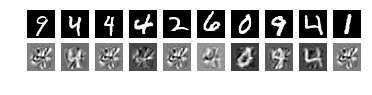

In [37]:
net1.eval()
visualize(net1, X_test[nnominal - 200:], in_size=[28*28], dtype=FloatTensor)

In [38]:
X_codes = encoder1(Variable(torch.from_numpy(X_train_ae))).data.numpy()

In [39]:
X_codes.shape

(5124, 49)

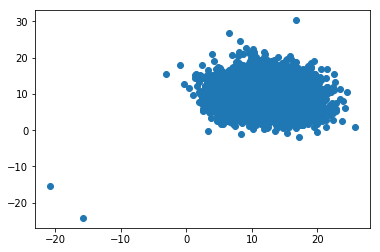

In [42]:
plt.scatter(X_codes[:, 0], X_codes[:, 1]);

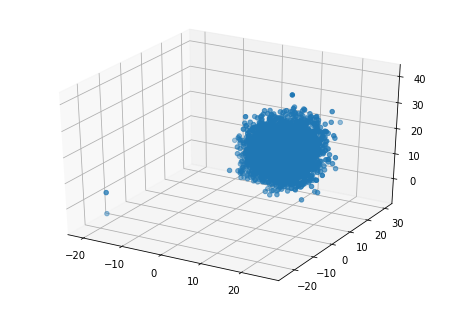

In [43]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = pylab.figure()
ax = Axes3D(fig)

ax.scatter(*zip(*X_codes[:, :3]));

In [44]:
#Encoder
class Q_net(nn.Module):
    def __init__(self):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3gauss = nn.Linear(N, z_dim)
    def forward(self, x):
        x = F.droppout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.droppout(self.lin2(x), p=0.25, training=self.training)
        x = F.relu(x)
        xgauss = self.lin3gauss(x)
        return xgauss
    
# Decoder
class P_net(nn.Module):
    def __init__(self):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)
    def forward(self, x):
        x = self.lin1(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin3(x)
        return F.sigmoid(x)
    
    
# Discriminator
class D_net_gauss(nn.Module):
    def __init__(self):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 1)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)
        return F.sigmoid(self.lin3(x))

In [46]:
torch.manual_seed(10)
Q, P = Q_net(), P_net(0)     # Encoder/Decoder
D_gauss = D_net_gauss()                # Discriminator adversarial
if torch.cuda.is_available():
    Q = Q.cuda()
    P = P.cuda()
    D_cat = D_gauss.cuda()
    D_gauss = D_net_gauss().cuda()
# Set learning rates
gen_lr, reg_lr = 0.0006, 0.0008
# Set optimizators
P_decoder = optim.Adam(P.parameters(), lr=gen_lr)
Q_encoder = optim.Adam(Q.parameters(), lr=gen_lr)
Q_generator = optim.Adam(Q.parameters(), lr=reg_lr)
D_gauss_solver = optim.Adam(D_gauss.parameters(), lr=reg_lr)

NameError: name 'X_dim' is not defined